<h2><center>BORN AGAIN NETWORKS ON BINARY CLASSIFICATION</center></h2>

In this notebook we are going to test a Wide Residual Network on a binary classification dataset from kaggle,


In [1]:
#Import of all needed packages
import tensorflow as tf
from BANEnsemble import BANEnsemble
from WideResNet import WideResidualNetwork
from knowledge_distillation import *

Let's mount google drive in order to import the dataset, that comes from kaggle at the link [Skin Cancer](https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign).

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
! unzip /content/drive/My\ Drive/datasets/skin_cancer.zip 

Output streaming troncato alle ultime 5000 righe.
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/447.jpg  
  inflating: data/train/benign/448.jpg  
  inflat

In [66]:
# DATA AUGMENTATION, in this case, to speed up the train, the images are resized from (224, 224) to (64, 64)

BATCH_SIZE = 32


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,
        rescale=1./255,
        validation_split=0.15)  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = train_datagen.flow_from_directory(
        '/content/data/train',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        seed=2,
        subset='training')
validation_generator = valid_datagen.flow_from_directory(
        '/content/data/train',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        seed=2,
        class_mode='binary',
        subset='validation')
test_generator = test_datagen.flow_from_directory(
        '/content/data/test',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 2242 images belonging to 2 classes.
Found 395 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Now we can use pyplot just to have an idea of the augmented dataset



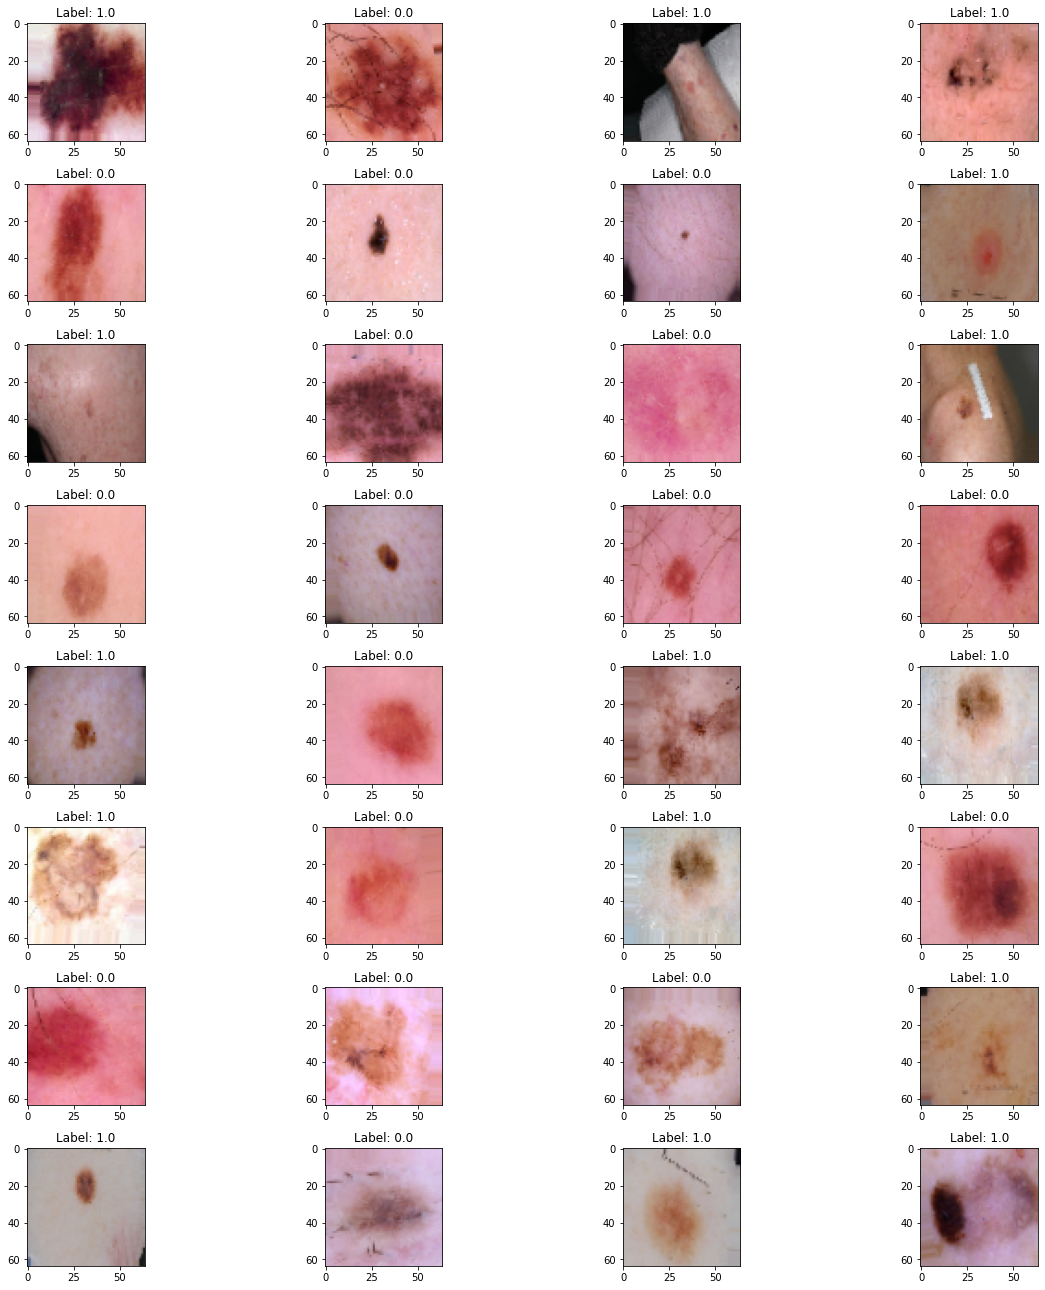

In [67]:
import matplotlib.pyplot as plt
ROWS = 8
COLUMNS = 4
FIGSIZE = (6, 6)

images, labels =train_generator.next()




fig, ax = plt.subplots(nrows=ROWS, ncols=COLUMNS,figsize=(18, 18))
# plot simple raster image on each sub-plot
for (i, axi), (image, label) in zip(enumerate(ax.flat), zip(images, labels)):

    axi.imshow(image)

   
    axi.set_title("Label: "+str(label))


plt.tight_layout(True)
plt.show()

In [69]:
# Building of the teacher model
teacher_model = tf.keras.models.Sequential([
                                            WideResidualNetwork(1, 28, 1,includeActivation=False),
                                            tf.keras.layers.Activation('sigmoid')
])

In [77]:
# Compiling the model
optimizer_sgd = tf.keras.optimizers.SGD()
teacher_model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])


In [78]:
# Callbacks definition and model training
es_callback = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
rop_callback = tf.keras.callbacks.ReduceLROnPlateau(factor=0.001, patience=5) # Useful in case of SGD
history = teacher_model.fit(train_generator, callbacks=[es_callback, rop_callback], steps_per_epoch=train_generator.samples//BATCH_SIZE, validation_data=validation_generator, validation_steps=validation_generator.samples//BATCH_SIZE, epochs=150)

Epoch 1/150
70/70 [==============================] - 9s 131ms/step - loss: 0.5854 - accuracy: 0.7240 - val_loss: 4.2215 - val_accuracy: 0.5599
Epoch 2/150
70/70 [==============================] - 8s 118ms/step - loss: 0.4757 - accuracy: 0.7674 - val_loss: 1.2562 - val_accuracy: 0.6250
Epoch 3/150
70/70 [==============================] - 8s 119ms/step - loss: 0.4724 - accuracy: 0.7754 - val_loss: 0.8821 - val_accuracy: 0.5911
Epoch 4/150
70/70 [==============================] - 8s 118ms/step - loss: 0.5372 - accuracy: 0.7633 - val_loss: 1.8951 - val_accuracy: 0.6849
Epoch 5/150
70/70 [==============================] - 8s 117ms/step - loss: 0.4373 - accuracy: 0.7887 - val_loss: 10.1411 - val_accuracy: 0.4714
Epoch 6/150
70/70 [==============================] - 8s 118ms/step - loss: 0.5276 - accuracy: 0.7516 - val_loss: 1.0112 - val_accuracy: 0.6042
Epoch 7/150
70/70 [==============================] - 8s 118ms/step - loss: 0.4651 - accuracy: 0.7778 - val_loss: 0.6449 - val_accuracy: 0.726

In [79]:
teacher_model.save_weights('teacher_model.h5')

In [80]:
teacher_model.evaluate(validation_generator)

13/13 [==============================] - 1s 59ms/step - loss: 0.4266 - accuracy: 0.7924


[0.42662566900253296, 0.7924050688743591]

In [81]:
build_student = lambda : tf.keras.models.Sequential([
                                            WideResidualNetwork(1, 28, 1, includeActivation=False),
                                            tf.keras.layers.Activation('sigmoid')
])
student_callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [82]:
def distill_knowledge(teacher_model, student_model, train_dataset, valid_data, 
                      student_callbacks, epochs, batch_size, steps_per_epoch, validation_steps):
  def custom_generator(train_dataset, t_model):
    for (x, y) in train_dataset:
      y_targets = teacher_model(x)
      yield (x, y_targets)

  s_history = student_model.fit(custom_generator(train_dataset, 
                                                 t_model=teacher_model),             
                      epochs=epochs,
                      steps_per_epoch=steps_per_epoch,
                      callbacks = student_callbacks,
                      validation_data=valid_data,
                      validation_steps=validation_steps)

  return s_history


def ban(teacher_model, n_students, build_model, 
        train_dataset, valid_data, student_callbacks, 
        epochs, batch_size, steps_per_epoch, validation_steps,
        compile_args={'optimizer':'adam', 
                      'loss': 'categorical_crossentropy', 
                      'metrics': ['accuracy']}):
  students = [build_model() for i in range(n_students)]
  students.insert(0, teacher_model)
  for student in students:
    student.compile(optimizer=compile_args['optimizer'], loss=compile_args['loss'], 
                    metrics=compile_args['metrics'])
  history = []


  for i in range(1, len(students)):
    print("Training BAN-{}".format(i))
    current_history = distill_knowledge(students[i-1], 
                                        students[i], train_dataset, 
                                        valid_data, student_callbacks, 
                                        epochs, batch_size, steps_per_epoch, validation_steps)   
    history.append(current_history)
  return history, students

In [83]:
compile_args={'optimizer':'adam', 
                      'loss': 'binary_crossentropy', 
                      'metrics': ['accuracy']}

In [84]:
history, students = ban(teacher_model,3, build_student, train_generator, validation_generator, 
                        [student_callback], 150, BATCH_SIZE, 
                        steps_per_epoch = train_generator.samples//BATCH_SIZE, validation_steps=validation_generator.samples//BATCH_SIZE,
                        compile_args=compile_args)

Training BAN-1
Epoch 1/150
70/70 [==============================] - 10s 144ms/step - loss: 0.5848 - accuracy: 0.0000e+00 - val_loss: 1.2452 - val_accuracy: 0.5495
Epoch 2/150
70/70 [==============================] - 10s 137ms/step - loss: 0.5092 - accuracy: 0.0000e+00 - val_loss: 7.3868 - val_accuracy: 0.5417
Epoch 3/150
70/70 [==============================] - 10s 138ms/step - loss: 0.4518 - accuracy: 0.0000e+00 - val_loss: 1.6658 - val_accuracy: 0.5625
Epoch 4/150
70/70 [==============================] - 10s 138ms/step - loss: 0.4242 - accuracy: 0.0000e+00 - val_loss: 1.8903 - val_accuracy: 0.5417
Epoch 5/150
70/70 [==============================] - 10s 137ms/step - loss: 0.4282 - accuracy: 0.0000e+00 - val_loss: 1.8739 - val_accuracy: 0.5573
Epoch 6/150
70/70 [==============================] - 10s 139ms/step - loss: 0.4316 - accuracy: 0.0000e+00 - val_loss: 0.4636 - val_accuracy: 0.7682
Epoch 7/150
70/70 [==============================] - 10s 138ms/step - loss: 0.4287 - accuracy: 0.

In [85]:
for student in students:
  student.evaluate(test_generator)

21/21 [==============================] - 1s 61ms/step - loss: 0.3989 - accuracy: 0.7939


In [86]:
ban_model = BANEnsemble(students)

In [87]:
ban_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [88]:
ban_model.evaluate(test_generator)

21/21 [==============================] - 1s 69ms/step - loss: 0.4018 - accuracy: 0.8000


[0.40179628133773804, 0.800000011920929]